# Q-A exploration - Statistics
A script to analyse the avoidance corpus w.r.t. ngram frequencies, ngrams z-scores (using the Convokit FightingWords model) and the edit distance of question-answer pairs.

Author: Karina Hensel

In [1]:
import os

from convokit import Corpus, download
from convokit import FightingWords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

import nltk
from nltk import FreqDist, tokenize, word_tokenize
from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import edit_distance

import spacy

## Load corpus
Load all Q-A pairs for further exploration.

In [38]:
# Load corpora
CORP_PATH = os.path.dirname(os.getcwd()) + "\\Corpora\\"
all_answers = Corpus(CORP_PATH+'full-avoidance-corpus')
avoid = Corpus(CORP_PATH+'avoidance-corpus')
av_fight = Corpus(CORP_PATH+'fight-corpus')
av_flight = Corpus(CORP_PATH+'flight-corpus')

In [39]:
# Remove stop words
def remove_stopwords(stop_words, sent):
    word_tokens = word_tokenize(sent)
  
    filtered_sent = [] 
  
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sent.append(w)
    
    return ' '.join(filtered_sent)

In [40]:
# Get frequency distributions for all corpora
all_freqDist = nltk.FreqDist()
av_freqDist = nltk.FreqDist()
fight_freqDist = nltk.FreqDist()
flight_freqDist = nltk.FreqDist()
    
for utt in all_answers.iter_utterances():
    all_freqDist.update(nltk.word_tokenize(utt.text))

for utt in avoid.iter_utterances():
    av_freqDist.update(nltk.word_tokenize(utt.text))

for utt in av_fight.iter_utterances():
    fight_freqDist.update(nltk.word_tokenize(utt.text))

for utt in av_flight.iter_utterances():
    flight_freqDist.update(nltk.word_tokenize(utt.text))

# Obtain top 20 stopwords
stopwords_all = [w for (w, f) in all_freqDist.most_common(20)]
stopwords_av = [w for (w, f) in all_freqDist.most_common(20)]
stopwords_fight = [w for (w, f) in all_freqDist.most_common(20)]
stopwords_flight = [w for (w, f) in all_freqDist.most_common(20)]

# Remove stop words
for utt in all_answers.iter_utterances():
    utt.text = remove_stopwords(stopwords_all, utt.text)

for utt in avoid.iter_utterances():
    utt.text = remove_stopwords(stopwords_av, utt.text)

for utt in av_fight.iter_utterances():
    utt.text = remove_stopwords(stopwords_fight, utt.text)

for utt in av_flight.iter_utterances():
    utt.text = remove_stopwords(stopwords_flight, utt.text)

## Data exploration / linguistic indicators
### (1) Bigram and trigram frequencies for avoidance / non-avoidance and different strategies
#### 1.2 Avoidance vs. non-avoidance
Estimate bi- and trigram frequencies for avoidance and non-avoidance answers.

In [41]:
# Most frequent bi- and trigrams for avoidance / non-avoidance
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

def plot_ngram_freqs(ngrams, freqs, title):
    fig, x = plt.subplots(figsize=(10, 6))
    x.scatter(ngrams, freqs)
    plt.setp(x.get_xticklabels(), rotation = 45)
    plt.title(title)
    #plt.savefig(title+'.png')
    plt.show()
    

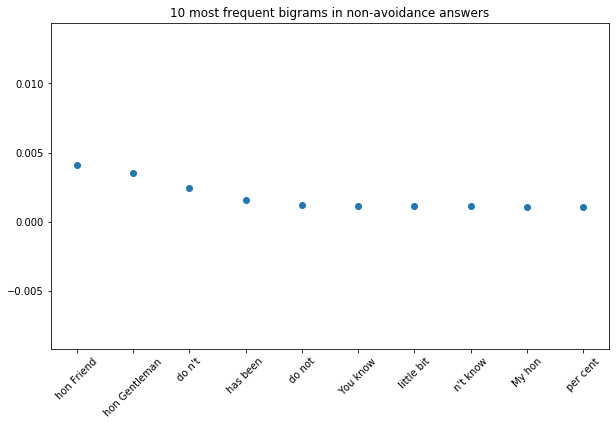

['hon Friend', 'hon Gentleman', "do n't", 'has been', 'do not', 'You know', 'little bit', "n't know", 'My hon', 'per cent']


In [42]:
# Bigrams non-avoidance
non_av = [utt.text for utt in all_answers.iter_utterances() if utt.reply_to!=None]
non_av_freq = BigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(non_av)), window_size=2)

non_av_bi_freqs = [f for n, f in non_av_freq.score_ngrams(bigram_measures.raw_freq)[:10]]
non_av_bigrams = [n[0] + ' ' + n[1] for n, f in non_av_freq.score_ngrams(bigram_measures.raw_freq)[:10]]

plot_ngram_freqs(non_av_bigrams, non_av_bi_freqs, '10 most frequent bigrams in non-avoidance answers')
print(non_av_bigrams)

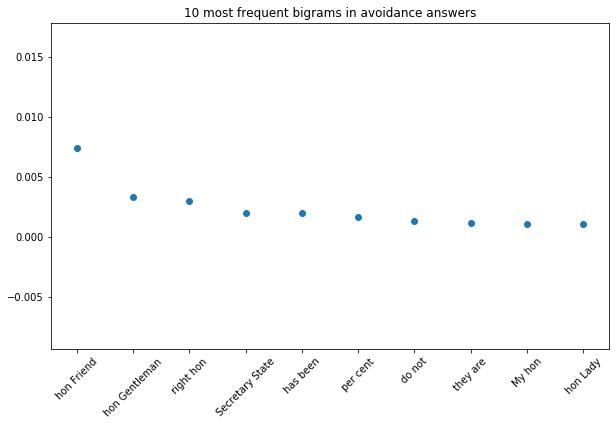

['hon Friend', 'hon Gentleman', 'right hon', 'Secretary State', 'has been', 'per cent', 'do not', 'they are', 'My hon', 'hon Lady']


In [43]:
# Bigrams avoidance
av = [utt.text for utt in av_fight.iter_utterances()] + [utt.text for utt in av_flight.iter_utterances()]

av_freq = BigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(av)))

av_bi_freqs = [f for n, f in av_freq.score_ngrams(bigram_measures.raw_freq)[:10]]
av_bigrams = [n[0] + ' ' + n[1] for n, f in av_freq.score_ngrams(bigram_measures.raw_freq)[:10]]
plot_ngram_freqs(av_bigrams, av_bi_freqs, '10 most frequent bigrams in avoidance answers')
print(av_bigrams)

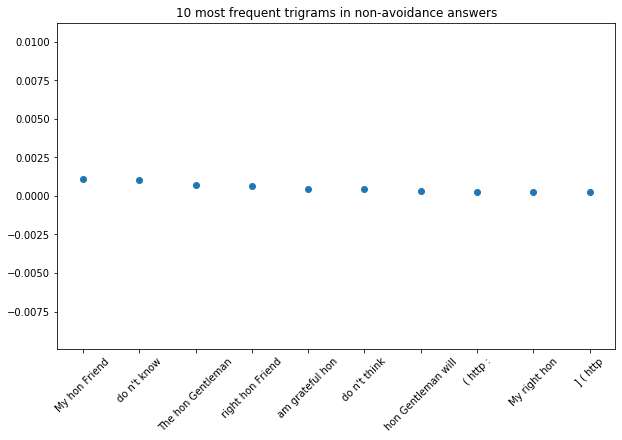

['My hon Friend', "do n't know", 'The hon Gentleman', 'right hon Friend', 'am grateful hon', "do n't think", 'hon Gentleman will', '( http :', 'My right hon', '] ( http']


In [44]:
# Trigrams non-avoidance
non_av_freq3 = TrigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(non_av)), window_size=3)

non_av_tri_freqs = [f for n, f in non_av_freq3.score_ngrams(bigram_measures.raw_freq)[:10]]
non_av_trigrams = [n[0]+ ' ' + n[1] + ' ' + n[2] for n, f in non_av_freq3.score_ngrams(bigram_measures.raw_freq)[:10]]

plot_ngram_freqs(non_av_trigrams, non_av_tri_freqs, '10 most frequent trigrams in non-avoidance answers')
print(non_av_trigrams)

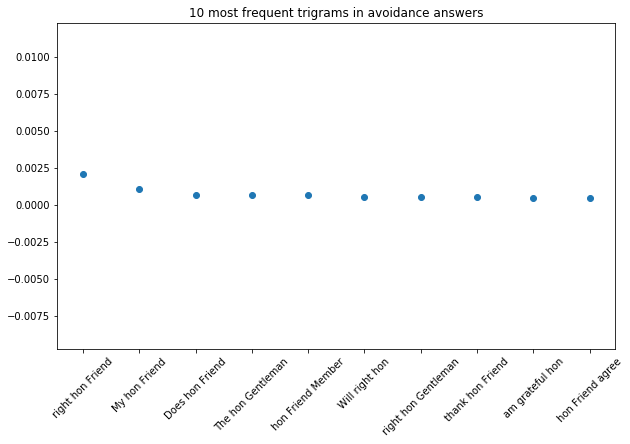

['right hon Friend', 'My hon Friend', 'Does hon Friend', 'The hon Gentleman', 'hon Friend Member', 'Will right hon', 'right hon Gentleman', 'thank hon Friend', 'am grateful hon', 'hon Friend agree']


In [45]:
# Trigrams avoidance
av_freq3 = TrigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(av)), window_size=3)

av_tri_freqs = [f for n, f in av_freq3.score_ngrams(bigram_measures.raw_freq)[:10]]
av_trigrams = [n[0]+ ' ' + n[1] + ' ' + n[2] for n, f in av_freq3.score_ngrams(bigram_measures.raw_freq)[:10]]
plot_ngram_freqs(av_trigrams, av_tri_freqs, '10 most frequent trigrams in avoidance answers')
print(av_trigrams)

#### 1.2 'Fight' vs. 'Flight'
Estimate bi- and trigram frequencies for 'Fight' and 'Flight' answers.

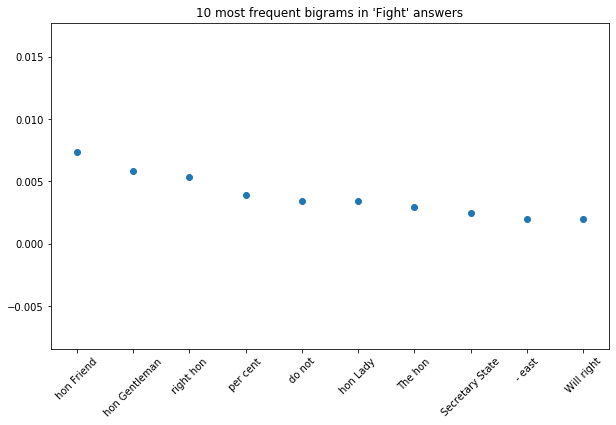

['hon Friend', 'hon Gentleman', 'right hon', 'per cent', 'do not', 'hon Lady', 'The hon', 'Secretary State', '- east', 'Will right']


In [46]:
# Bigrams 'Fight'
fight = [utt.text for utt in av_fight.iter_utterances()]
fight_freq = BigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(fight)), window_size=2)

fight_bi_freqs = [f for n, f in fight_freq.score_ngrams(bigram_measures.raw_freq)[:10]]
fight_bigrams = [n[0] + ' ' + n[1] for n, f in fight_freq.score_ngrams(bigram_measures.raw_freq)[:10]]

plot_ngram_freqs(fight_bigrams, fight_bi_freqs, '10 most frequent bigrams in \'Fight\' answers')
print(fight_bigrams)

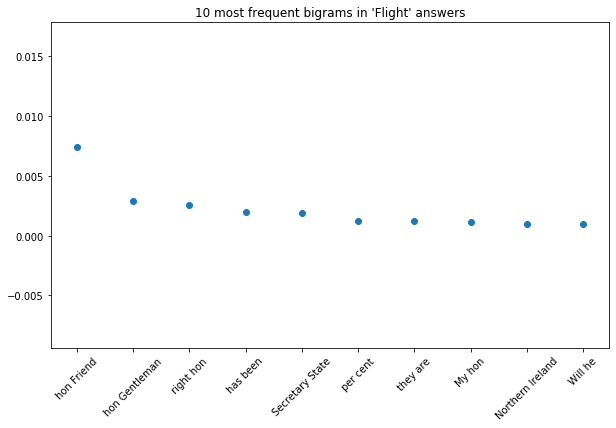

['hon Friend', 'hon Gentleman', 'right hon', 'has been', 'Secretary State', 'per cent', 'they are', 'My hon', 'Northern Ireland', 'Will he']


In [47]:
# Bigrams 'Flight'
flight = [utt.text for utt in av_flight.iter_utterances()]
flight_freq = BigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(flight)), window_size=2)

flight_bi_freqs = [f for n, f in flight_freq.score_ngrams(bigram_measures.raw_freq)[:10]]
flight_bigrams = [n[0] + ' ' + n[1] for n, f in flight_freq.score_ngrams(bigram_measures.raw_freq)[:10]]

plot_ngram_freqs(flight_bigrams, flight_bi_freqs, '10 most frequent bigrams in \'Flight\' answers')
print(flight_bigrams)

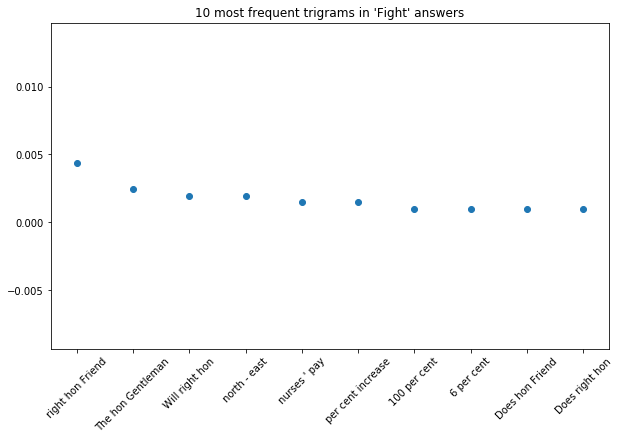

['right hon Friend', 'The hon Gentleman', 'Will right hon', 'north - east', "nurses ' pay", 'per cent increase', '100 per cent', '6 per cent', 'Does hon Friend', 'Does right hon']


In [48]:
# Trigrams 'Fight'
fight_freq3 = TrigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(fight)), window_size=3)

fight_tri_freqs3 = [f for n, f in fight_freq3.score_ngrams(bigram_measures.raw_freq)[:10]]
fight_trigrams = [n[0] + ' ' + n[1] + ' ' + n[2] for n, f in fight_freq3.score_ngrams(bigram_measures.raw_freq)[:10]]

plot_ngram_freqs(fight_trigrams, fight_tri_freqs3, '10 most frequent trigrams in \'Fight\' answers')
print(fight_trigrams)

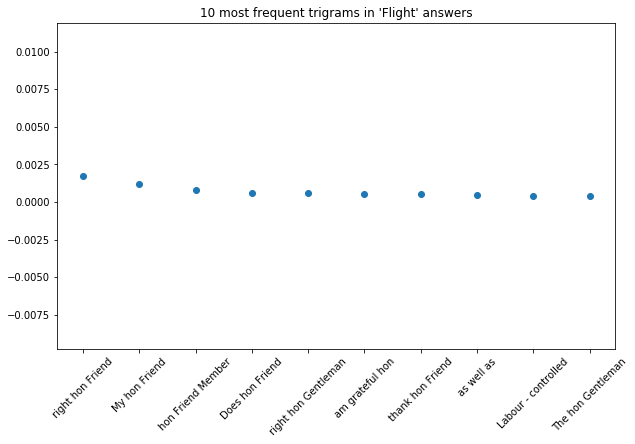

['right hon Friend', 'My hon Friend', 'hon Friend Member', 'Does hon Friend', 'right hon Gentleman', 'am grateful hon', 'thank hon Friend', 'as well as', 'Labour - controlled', 'The hon Gentleman']


In [49]:
# Trigrams 'Flight'
flight_freq3 = TrigramCollocationFinder.from_words(nltk.word_tokenize('\n'.join(flight)), window_size=3)

flight_tri_freqs3 = [f for n, f in flight_freq3.score_ngrams(trigram_measures.raw_freq)[:10]]
flight_trigrams = [n[0] + ' ' + n[1] + ' ' + n[2] for n, f in flight_freq3.score_ngrams(trigram_measures.raw_freq)[:10]]

plot_ngram_freqs(flight_trigrams, flight_tri_freqs3, '10 most frequent trigrams in \'Flight\' answers')
print(flight_trigrams)

### (2) z-scores of ngrams for avoidance / non-avoidance and different strategies
#### 2.1 Avoidance vs. non-avoidance
Plot the log-odds ratio against frequency of the most frequent words for avoidance (class 1) and non-avoidance answers (class 2) respectively.
If an ngram has a z-score outside of \[-1.96, 1.96\] of belonging to one of two classes, it is very likely to be a feature of that class.

Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 544 valid utterances. class2_func returned 300 valid utterances.
Vocab size is 538
Comparing language...
ngram zscores computed.


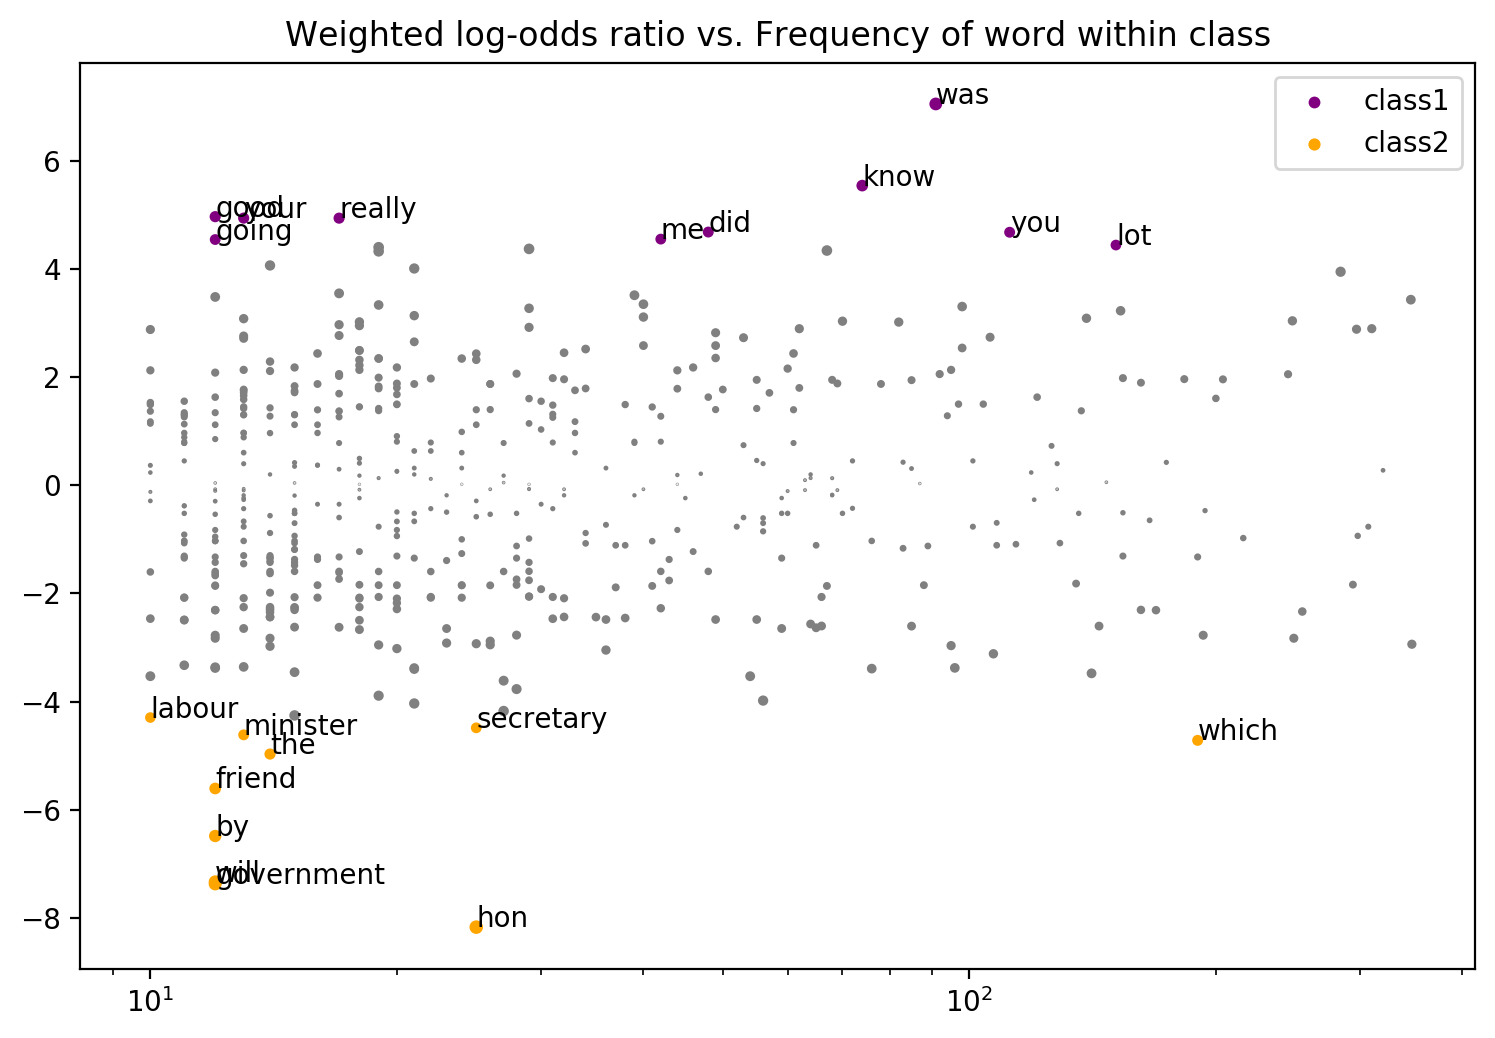

,z-score,class
ngram,,
hon,-8.174344,class2
government,-7.374302,class2
will,-7.336377,class2
by,-6.488180,class2
friend,-5.609152,class2
...,...,...
really,4.942566,class1
your,4.943409,class1
good,4.969899,class1


In [50]:
# Extract fighting words from selected avoidance and non-avoidance
fw1 = FightingWords(ngram_range=(1,1))
fw1.fit(all_answers, class1_func = lambda utt: utt not in av_fight.iter_utterances() and utt not in av_flight.iter_utterances(), 
        class2_func = lambda utt: utt in av_fight.iter_utterances() or utt in av_flight.iter_utterances())

# Plot
fw1.plot_fighting_words(max_label_size=15)
fw1.summarize(all_answers)

In [51]:
# Most frequent ngrams for non-avoidance
print('10 most frequent words in non-avoidance answers: ', fw1.get_top_k_ngrams()[0])

# Most frequent ngrams for avoidance
print('10 most frequent words in avoidance answers: ', fw1.get_top_k_ngrams()[1])

10 most frequent words in non-avoidance answers:  ['was', 'know', 'good', 'your', 'really', 'did', 'you', 'me', 'going', 'lot']
10 most frequent words in avoidance answers:  ['hon', 'government', 'will', 'by', 'friend', 'the', 'which', 'minister', 'secretary', 'labour']


Initializing default CountVectorizer with ngram_range (2, 2)... Done.
class1_func returned 544 valid utterances. class2_func returned 300 valid utterances.
Vocab size is 78
Comparing language...
ngram zscores computed.


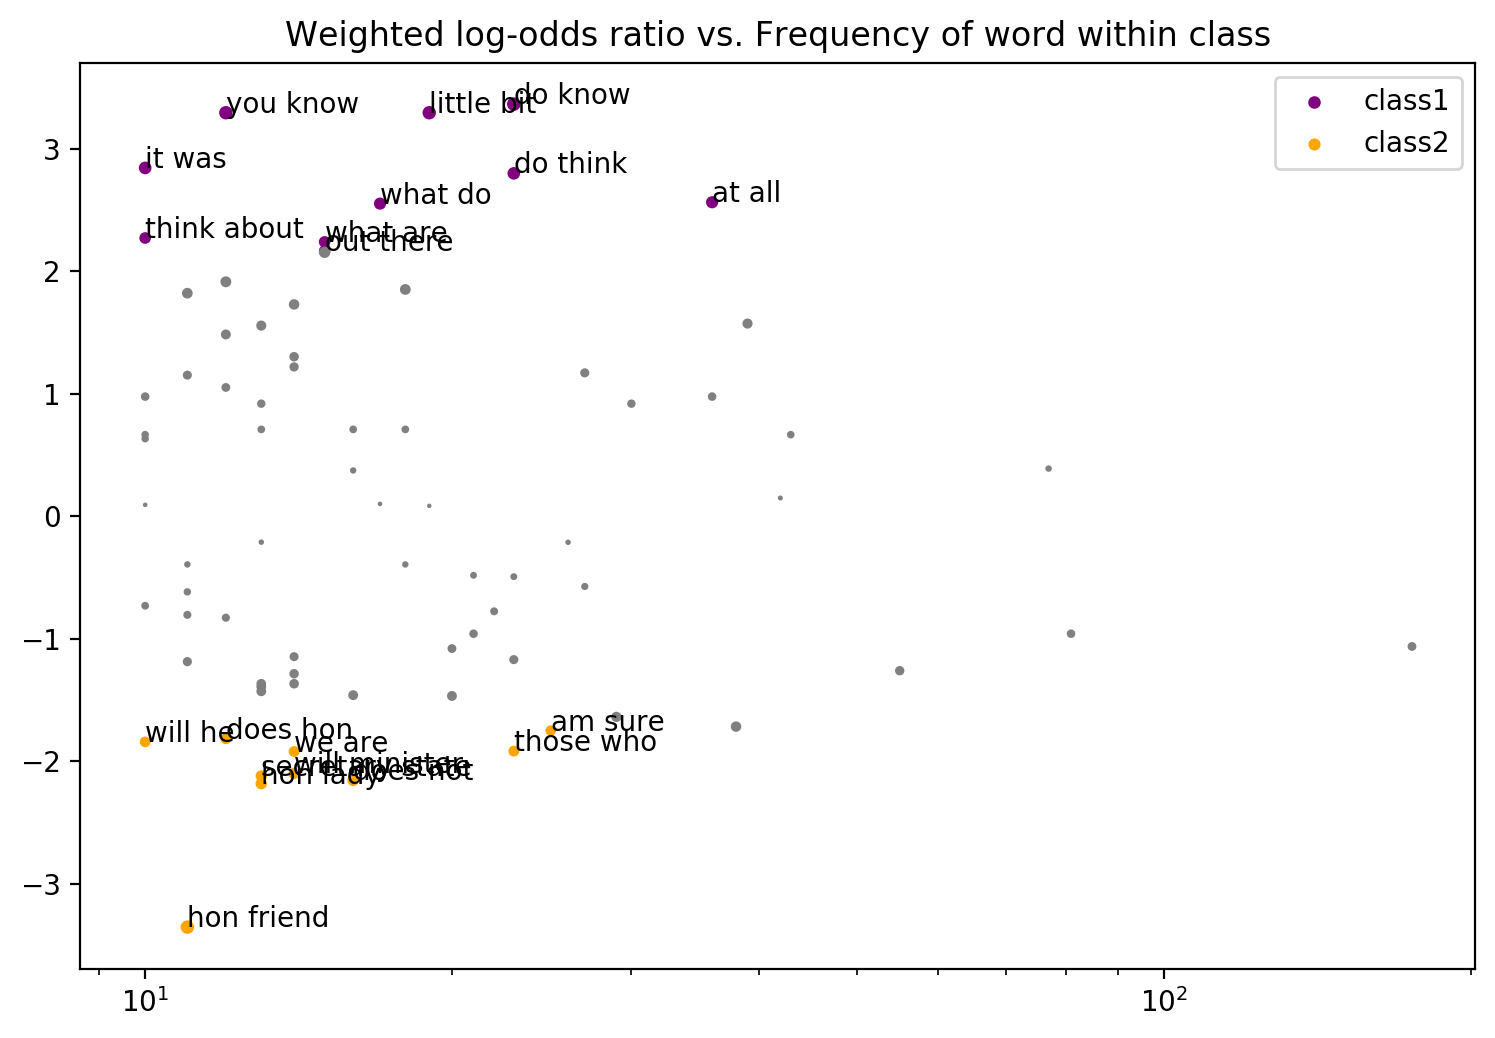

,z-score,class
ngram,,
hon friend,-3.352623,class2
hon lady,-2.180985,class2
does not,-2.154747,class2
secretary state,-2.118607,class2
will minister,-2.097873,class2
...,...,...
do think,2.800146,class1
it was,2.844703,class1
little bit,3.295064,class1


In [52]:
# Bigrams scores
fw2 = FightingWords(ngram_range=(2,2))
fw2.fit(all_answers, class1_func = lambda utt: utt not in av_fight.iter_utterances() and utt not in av_flight.iter_utterances(), 
        class2_func = lambda utt: utt in av_fight.iter_utterances() or utt in av_flight.iter_utterances())

# Plot
fw2.plot_fighting_words(max_label_size=15)
fw2.summarize(all_answers)

In [53]:
# Most frequent bigrams for non-avoidance
print('10 most frequent bigrams in non-avoidance answers: ', fw2.get_top_k_ngrams()[0])

# Most frequent bigrams for avoidance
print('10 most frequent bigrams in avoidance answers: ', fw2.get_top_k_ngrams()[1])

10 most frequent bigrams in non-avoidance answers:  ['do know', 'you know', 'little bit', 'it was', 'do think', 'at all', 'what do', 'think about', 'what are', 'out there']
10 most frequent bigrams in avoidance answers:  ['hon friend', 'hon lady', 'does not', 'secretary state', 'will minister', 'we are', 'those who', 'will he', 'does hon', 'am sure']


Initializing default CountVectorizer with ngram_range (3, 3)... Done.
class1_func returned 544 valid utterances. class2_func returned 300 valid utterances.
Vocab size is 8
Comparing language...
ngram zscores computed.


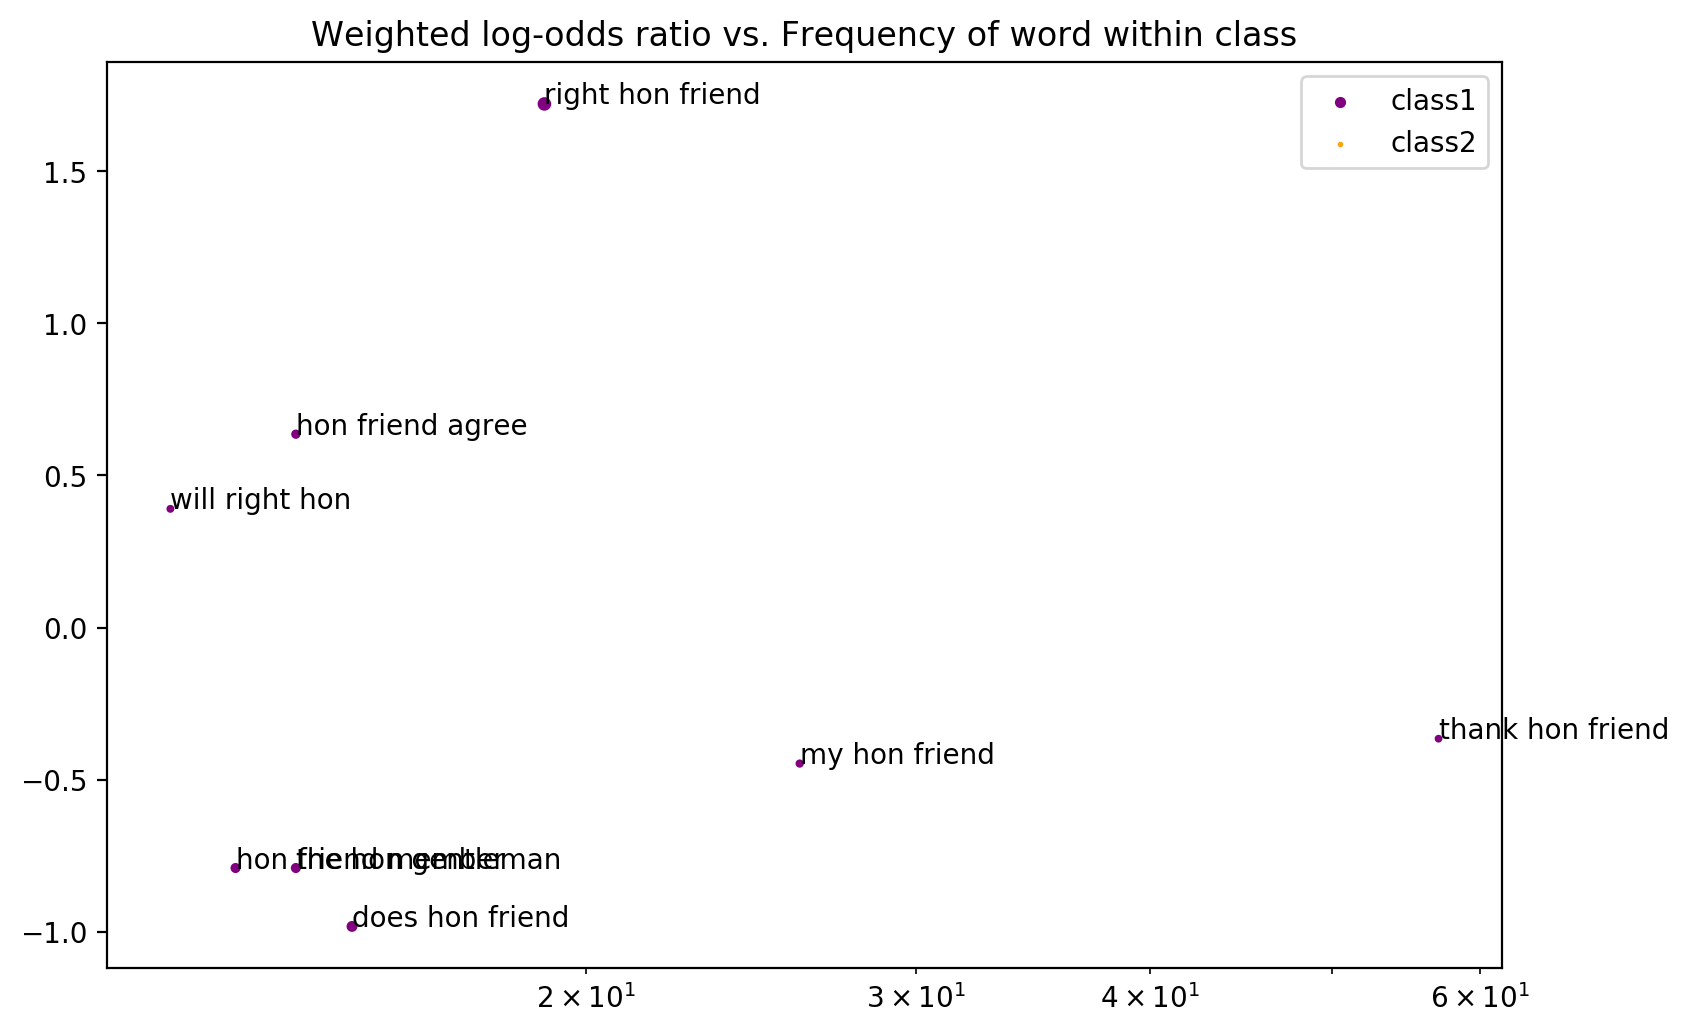

,z-score,class
ngram,,
does hon friend,-0.982017,class2
hon friend member,-0.790000,class2
the hon gentleman,-0.790000,class2
my hon friend,-0.446760,class2
thank hon friend,-0.365053,class2
will right hon,0.390330,class1
hon friend agree,0.635695,class1
right hon friend,1.721005,class1


In [54]:
# Trigrams scores
fw3 = FightingWords(ngram_range=(3,3))
fw3.fit(all_answers, class1_func = lambda utt: utt not in av_fight.iter_utterances() and utt not in av_flight.iter_utterances(), 
        class2_func = lambda utt: utt in av_fight.iter_utterances() or utt in av_flight.iter_utterances())

# Plot
fw3.plot_fighting_words(max_label_size=15)
fw3.summarize(all_answers)

In [55]:
# Most frequent trigrams for non-avoidance
print('10 most frequent trigrams in non-avoidance answers: ', fw3.get_top_k_ngrams()[0])

# Most frequent trigrams for avoidance
print('10 most frequent trigrams in avoidance answers: ', fw3.get_top_k_ngrams()[1])

10 most frequent trigrams in non-avoidance answers:  ['right hon friend', 'hon friend agree', 'will right hon', 'thank hon friend', 'my hon friend', 'the hon gentleman', 'hon friend member', 'does hon friend']
10 most frequent trigrams in avoidance answers:  ['does hon friend', 'hon friend member', 'the hon gentleman', 'my hon friend', 'thank hon friend', 'will right hon', 'hon friend agree', 'right hon friend']


#### 2.2 'Fight' vs. 'Flight'
Plot the log-odds ratio against frequency of the most frequent words for avoidance answers using the 'Fight' (class 1) and 'Flight' (class 2) strategy respectively.

Initializing default CountVectorizer with ngram_range (1, 1)... Done.
class1_func returned 38 valid utterances. class2_func returned 262 valid utterances.
Vocab size is 226
Comparing language...
ngram zscores computed.


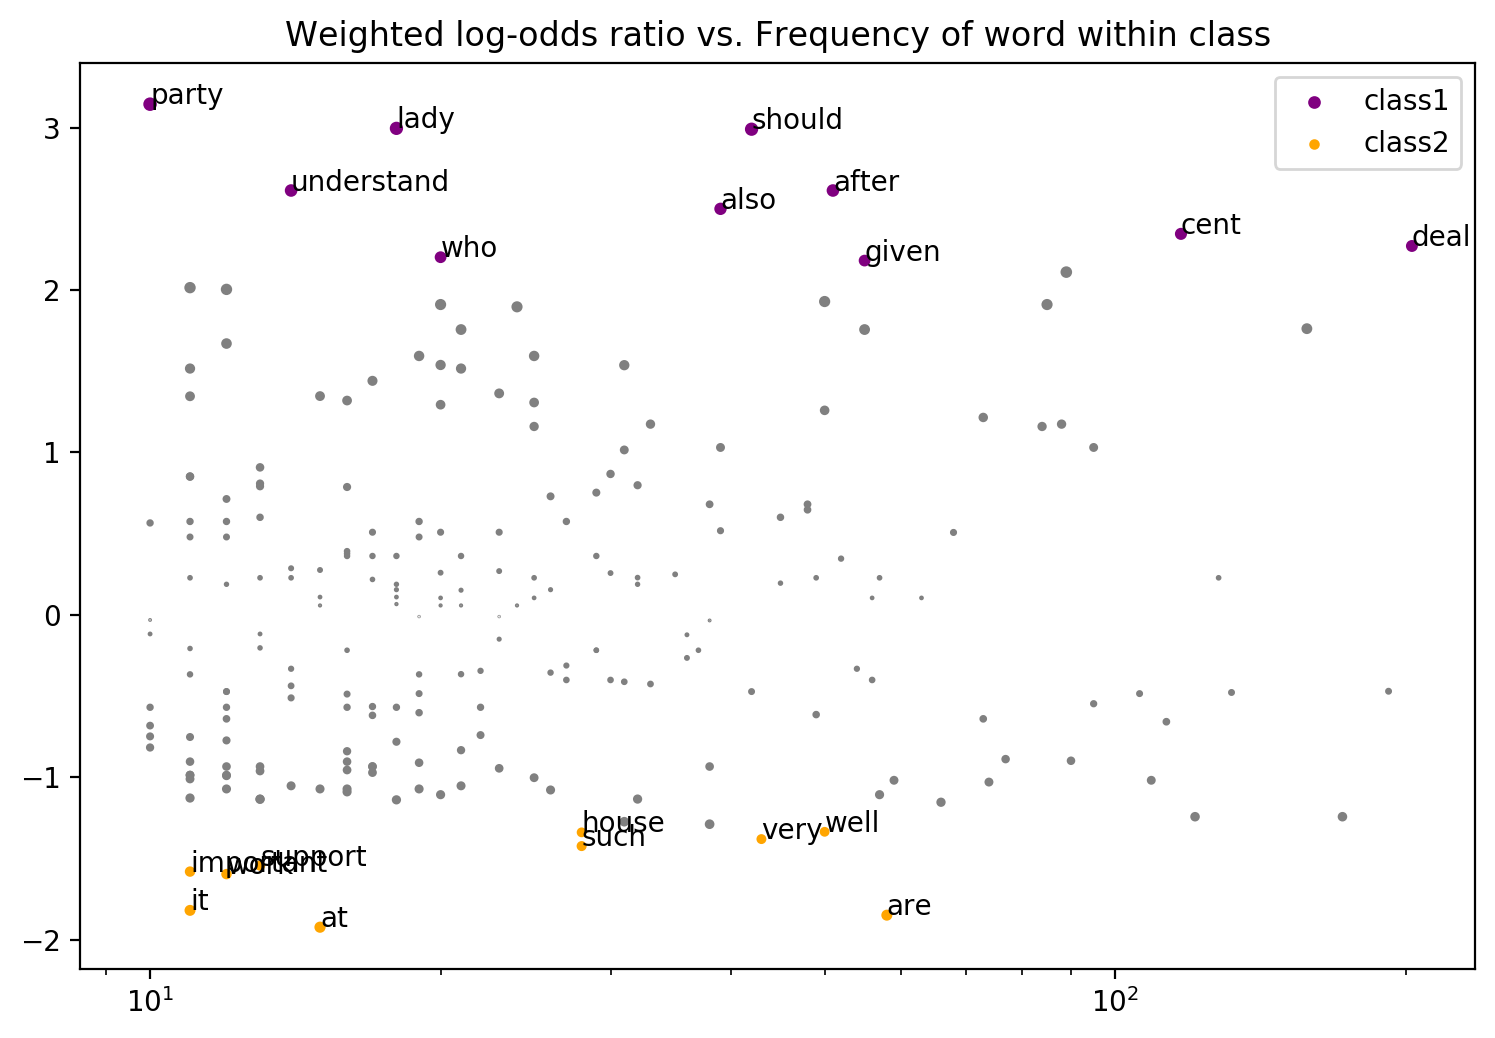

,z-score,class
ngram,,
at,-1.923763,class2
are,-1.849718,class2
it,-1.820204,class2
work,-1.596805,class2
important,-1.581394,class2
...,...,...
understand,2.612829,class1
after,2.612829,class1
should,2.990276,class1


In [56]:
# Extract fighting words from selected avoidance answers
fw1 = FightingWords(ngram_range=(1,1))
fw1.fit(all_answers, class1_func = lambda utt: utt in av_fight.iter_utterances(), 
        class2_func = lambda utt: utt in av_flight.iter_utterances())

# Plot
fw1.plot_fighting_words(max_label_size=15)
fw1.summarize(all_answers)

In [57]:
# Most frequent words for 'Fight'
print('10 most frequent words in\'Fight\' answers: ', fw1.get_top_k_ngrams()[0])

# Most frequent words for 'Flight'
print('10 most frequent words in \'Flight\' answers: ', fw1.get_top_k_ngrams()[1])

10 most frequent words in'Fight' answers:  ['party', 'lady', 'should', 'after', 'understand', 'also', 'cent', 'deal', 'who', 'given']
10 most frequent words in 'Flight' answers:  ['at', 'are', 'it', 'work', 'important', 'support', 'such', 'very', 'house', 'well']


Initializing default CountVectorizer with ngram_range (2, 2)... Done.
class1_func returned 38 valid utterances. class2_func returned 262 valid utterances.
Vocab size is 21
Comparing language...
ngram zscores computed.


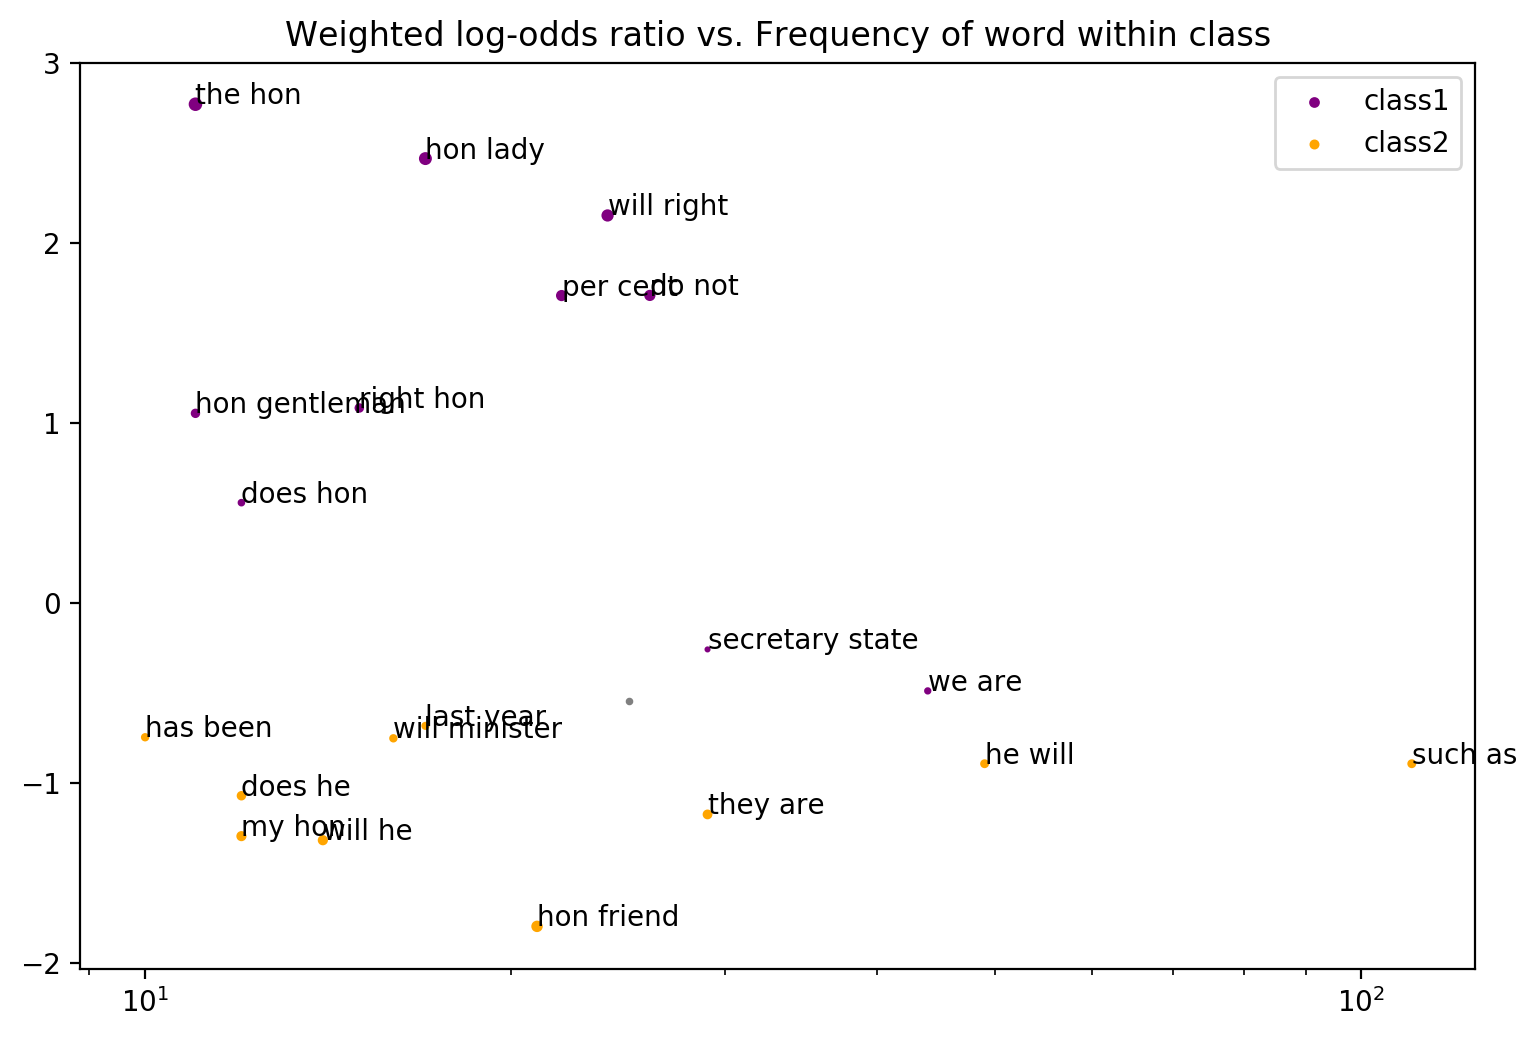

,z-score,class
ngram,,
hon friend,-1.797700,class2
will he,-1.318996,class2
my hon,-1.296409,class2
they are,-1.175764,class2
does he,-1.071984,class2
such as,-0.894035,class2
he will,-0.894035,class2
will minister,-0.752870,class2
has been,-0.747006,class2


In [58]:
# Bigram scores
fw2 = FightingWords(ngram_range=(2,2))
fw2.fit(all_answers, class1_func = lambda utt: utt in av_fight.iter_utterances(), 
        class2_func = lambda utt: utt in av_flight.iter_utterances())

# Plot
fw2.plot_fighting_words(max_label_size=15)
fw2.summarize(all_answers)

In [59]:
# Most frequent words for 'Fight'
print('10 most frequent bigrams in\'Fight\' answers: ', fw2.get_top_k_ngrams()[0])

# Most frequent words for 'Flight'
print('10 most frequent bigrams in \'Flight\' answers: ', fw2.get_top_k_ngrams()[1])

10 most frequent bigrams in'Fight' answers:  ['the hon', 'hon lady', 'will right', 'do not', 'per cent', 'right hon', 'hon gentleman', 'does hon', 'secretary state', 'we are']
10 most frequent bigrams in 'Flight' answers:  ['hon friend', 'will he', 'my hon', 'they are', 'does he', 'such as', 'he will', 'will minister', 'has been', 'last year']


Initializing default CountVectorizer with ngram_range (3, 3)... Done.
class1_func returned 38 valid utterances. class2_func returned 262 valid utterances.
Vocab size is 5
Comparing language...
ngram zscores computed.


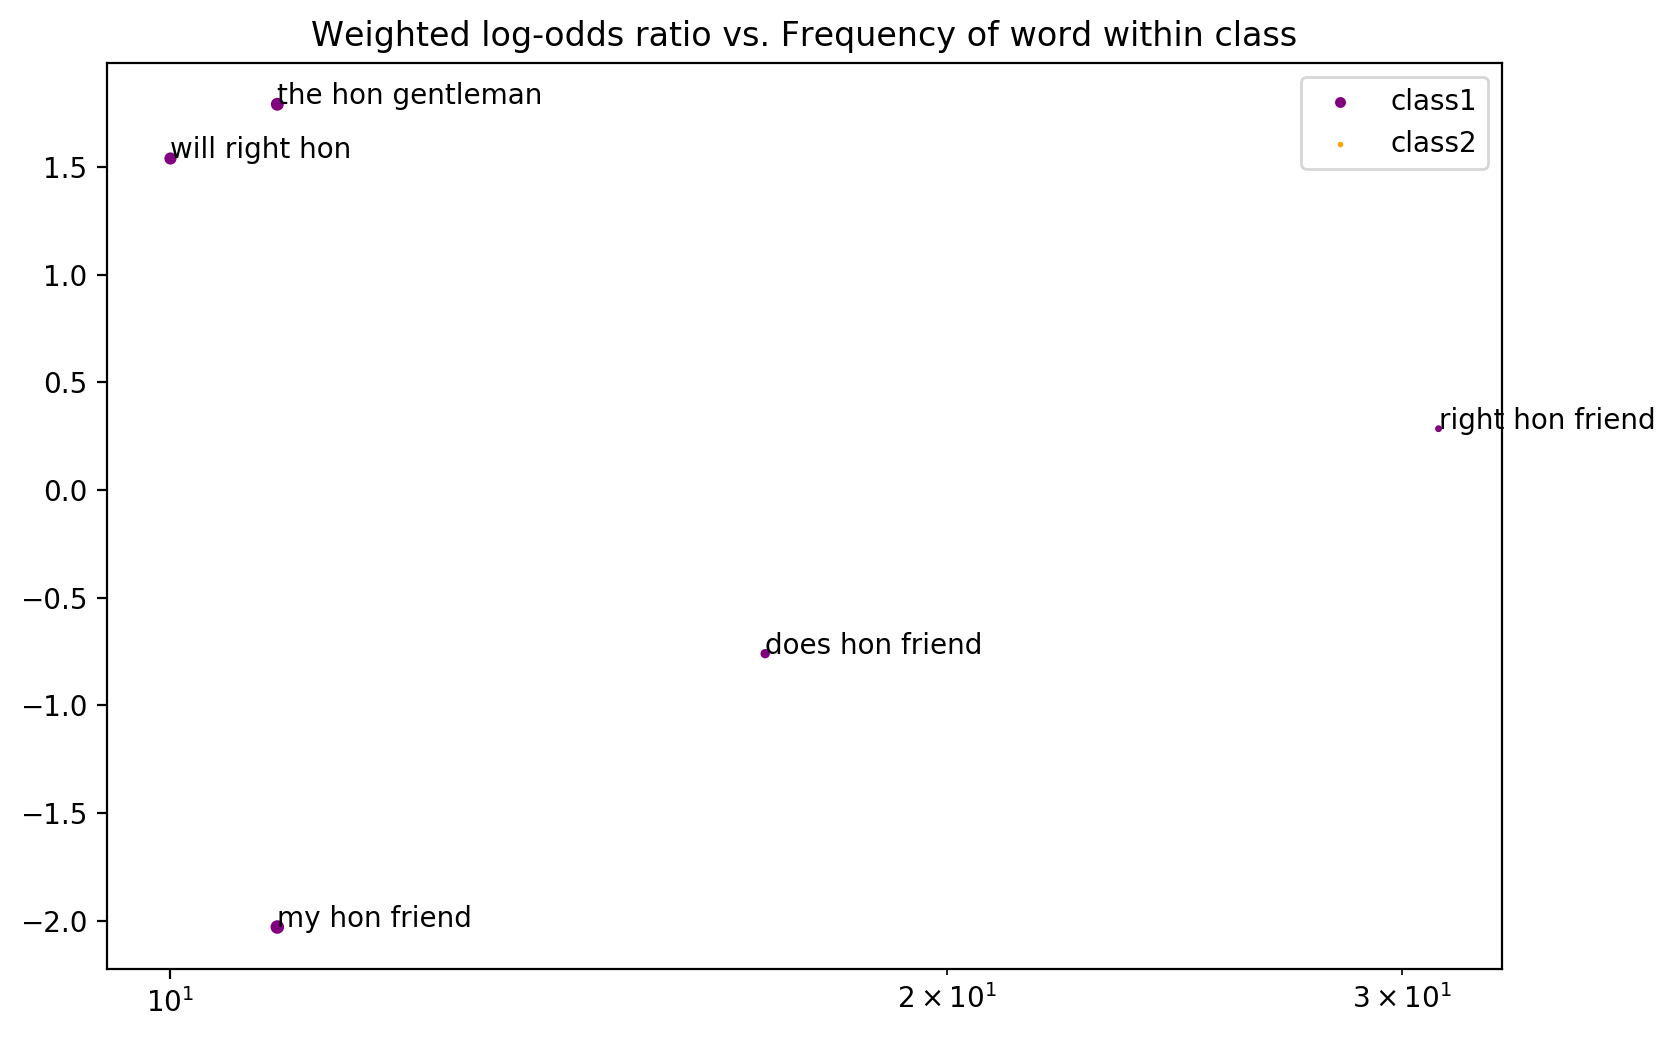

,z-score,class
ngram,,
my hon friend,-2.029183,class2
does hon friend,-0.760126,class2
right hon friend,0.284380,class1
will right hon,1.538953,class1
the hon gentleman,1.790637,class1


In [60]:
# Trigram scores
fw3 = FightingWords(ngram_range=(3,3))
fw3.fit(all_answers, class1_func = lambda utt: utt in av_fight.iter_utterances(), 
        class2_func = lambda utt: utt in av_flight.iter_utterances())

# Plot
fw3.plot_fighting_words(max_label_size=15)
fw3.summarize(all_answers)

In [61]:
# Most frequent words for 'Fight'
print('10 most frequent trigrams in\'Fight\' answers: ', fw3.get_top_k_ngrams()[0])

# Most frequent words for 'Flight'
print('10 most frequent trigrams in \'Flight\' answers: ', fw3.get_top_k_ngrams()[1])

10 most frequent trigrams in'Fight' answers:  ['the hon gentleman', 'will right hon', 'right hon friend', 'does hon friend', 'my hon friend']
10 most frequent trigrams in 'Flight' answers:  ['my hon friend', 'does hon friend', 'right hon friend', 'will right hon', 'the hon gentleman']


### (3) Levenshtein distance between question and answer
Investigate whether there are significant differences between the Levenshtein distances of avoidance / non-avoidance QA pairs and 'Fight'/'Flight' pairs.

In [62]:
def shorten_ques(question):
    """Shorten questions to the last two sentences"""
    sents = tokenize.sent_tokenize(question)
    qu = ''
        
    if len(sents) >= 2: 
            qu = str(sents[:len(sents)-2]) + '\n' + str(sents[len(sents)-1])
    else: 
            qu = str(sents[len(sents)-1])
    return qu
    
def shorten_answ(answer):
    """Shorten answers to the first two sentences"""
    sents = tokenize.sent_tokenize(answer)
    answ = ''
    
    if len(sents) >= 2: 
            answ = str(sents[0]) + '\n' + str(sents[1])
    else: 
            answ = str(sents[0])
    return answ 

In [63]:
# Average Levenshtein distance for non-avoidance Q-A pairs
non_av_dist = 0.0
non_av_distances = []

i = 0
for utt in avoid.iter_utterances():
    answer, question = '', ''
    if utt.speaker.id == 'answerer':
        answer = shorten_answ(utt.text)
        print(utt)
        question = shorten_ques(all_answers.get_utterance(utt.reply_to).text)
        
        dist = edit_distance(question, answer)
        non_av_distances.append(dist)
        i += 1
    else:
        pass

Utterance('id': '2009-06-02b.147.6', 'conversation_id': 2009-06-02b.147.3, 'reply-to': 2009-06-02b.147.3, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'That certainly not case am sure not what Prime Minister meant not least because—as reminded Opposition moment ago—there will very strong local authority involvement representation new bodies will consider proposals They are as said elected', 'meta': {'negation_score': 3, 'sentiment_score': 0.36493333333333333, 'negation_score_first2': 3, 'sentiment_score_first2': 0.5474, 'politeness_score': 0.507811239629772})
Utterance('id': '1986-01-14a.907.1', 'conversation_id': 1986-01-14a.906.10, 'reply-to': 1986-01-14a.906.10, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'am grateful hon learned Friend his welcome which greatly appreciate It important us all realise spin - off effects are not merely area which they are addressed—that say research into systems space—but they important conn

Utterance('id': '2000-05-16a.139.6', 'conversation_id': 2000-05-16a.139.0, 'reply-to': 2000-05-16a.139.0, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'can reassure hon Friend what any new arrangements will do The matter still under review but British Trade International IBB work extremely hard ensure opportunities investors Peterborough are made well known those who wish invest United Kingdom thank hon Friend all excellent work she does supporting local firms Peterborough winning new markets throughout world', 'meta': {'negation_score': 0, 'sentiment_score': 0.8551000000000001, 'negation_score_first2': 0, 'sentiment_score_first2': 0.8125, 'politeness_score': 0.9317236107491449})
Utterance('id': '6083_1.a', 'conversation_id': 6083_1.q, 'reply-to': 6083_1.q, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': "thought about match few weeks ago Madrid definitely changed few things up from there It definitely worked ca n't say went out 

Utterance('id': '2016-12-01c.1646.0', 'conversation_id': 2016-12-01c.1645.7, 'reply-to': 2016-12-01c.1645.7, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'The Government set out clear plan at autumn statement our strategic framework northern powerhouse We are spending £ 13 billion transport north establishing Transport North ensuring statutory status Investment north very substantial indeed borne out by improving—and indeed record—levels employment north', 'meta': {'negation_score': 0, 'sentiment_score': 0.3088666666666667, 'negation_score_first2': 0, 'sentiment_score_first2': 0.3275, 'politeness_score': 0.37053150740503366})
Utterance('id': '2002-03-12.744.1', 'conversation_id': 2002-03-12.742.2, 'reply-to': 2002-03-12.742.2, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'As far as compliance with United Nations resolutions concerned we United Kingdom Government are doing huge amount work which been involved from day assumed t

Utterance('id': '3406_1.a', 'conversation_id': 3406_1.q, 'reply-to': 3406_1.q, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': "When go play new match never think about what happened before You know we do n't big different Yeah 7-0 Yeah before won seven matches But know can lose before two three matches also maybe four All matches was very close So before win ; today he win", 'meta': {'negation_score': 2, 'sentiment_score': 0.25572857142857147, 'negation_score_first2': 2, 'sentiment_score_first2': 0.17, 'politeness_score': 0.277894015198267})
Utterance('id': '1986-01-14a.919.1', 'conversation_id': 1986-01-14a.918.11, 'reply-to': 1986-01-14a.918.11, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'refer hon Friend reply gave some moments ago', 'meta': {'negation_score': 0, 'sentiment_score': 0.4939, 'negation_score_first2': 0, 'sentiment_score_first2': 0.4939, 'politeness_score': 0.5362779572391109})
Utterance('id': '2005-01-26a.291.

Utterance('id': '1993-12-15a.1062.0', 'conversation_id': 1993-12-15a.1061.3, 'reply-to': 1993-12-15a.1061.3, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'am sure there will an opportunity debate matter The Prime Minister will make imagine fairly full statement tomorrow—that say if negotiations conclude way we hope Therefore shall not answer hon Gentleman question detail but would say common sense there should wind - down total exports subsidised grain from Europe It difficult farmers some countries—perhaps all countries—but think most hon Members House believe movement towards common sense', 'meta': {'negation_score': 1, 'sentiment_score': 0.17902500000000005, 'negation_score_first2': 0, 'sentiment_score_first2': 0.5386500000000001, 'politeness_score': 0.7418691956958922})
Utterance('id': '1994-03-07a.8.9', 'conversation_id': 1994-03-07a.8.6, 'reply-to': 1994-03-07a.8.6, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'join hon 

Utterance('id': 't1_cj02oy9', 'conversation_id': t3_2ays1r, 'reply-to': t3_2ays1r, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'built own using an RVZ01 but ended up using windows as OS Im waiting see if XBMC gets integrated any way Edit : Just found [ this ] ( http : //forum.xbmc.org/showthread.php tid=197422 ) so there hope', 'meta': {'negation_score': 0, 'sentiment_score': 0.16256666666666666, 'negation_score_first2': 0, 'sentiment_score_first2': 0.0, 'politeness_score': 0.5360520044989056})
Utterance('id': '1990-06-11a.3.3', 'conversation_id': 1990-06-11a.2.3, 'reply-to': 1990-06-11a.2.3, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'am grateful hon Gentleman reminding House great value electrification agree with him about electrification east coast main line which cost £ 450 million which was glad inaugurate two weeks ago am mindful arguments deployed favour electrification plan visit West Yorkshire passenger transport e

Utterance('id': '2012-02-06c.20.5', 'conversation_id': 2012-02-06c.20.2, 'reply-to': 2012-02-06c.20.2, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'My hon Friend highlights responsible tenancies My colleague Minister Housing Local Government right hon Member Welwyn Hatfield ( Grant Shapps ) doing further work ensure those who commit antisocial behaviour are not beneficiaries social housing inappropriate circumstances note hon Friend ’ s comments will draw them attention right hon Friend', 'meta': {'negation_score': 1, 'sentiment_score': 0.6764666666666667, 'negation_score_first2': 1, 'sentiment_score_first2': 0.6394, 'politeness_score': 0.507811239629772})
Utterance('id': '2009-02-23b.8.0', 'conversation_id': 2009-02-23b.7.3, 'reply-to': 2009-02-23b.7.3, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'First may pay tribute hon Gentleman other members all - party group Army arranging this afternoon event other ministerial collea

Utterance('id': '1984-05-14a.1.9', 'conversation_id': 1984-05-14a.1.8, 'reply-to': 1984-05-14a.1.8, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'The right hon Gentleman with his great interest these matters will delighted relieved know there no great battle going between myself Treasury this matter As he knows this major fairly complicated transaction involving great deal detail right matter such magnitude should considered very carefully It important ensure security supplies industry way will not retard development our own North sea resources That Government object their examination proposal', 'meta': {'negation_score': 1, 'sentiment_score': 0.618775, 'negation_score_first2': 0, 'sentiment_score_first2': 0.8269, 'politeness_score': 0.3963948196088106})
Utterance('id': '1988-06-28a.180.1', 'conversation_id': 1988-06-28a.179.8, 'reply-to': 1988-06-28a.179.8, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'hope hon Lady recognise

Utterance('id': '1991-03-20a.276.3', 'conversation_id': 1991-03-20a.275.4, 'reply-to': 1991-03-20a.275.4, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'The hon Gentleman comments are singularly inappropriate day after Budget pumped three quarters billion pounds into industry His comments are also inappropriate because his district Derwent 5,000 jobs were created 1980s because over past 10 years no less than £ 3·5 billion Government aid has been given north - east which was carefully targeted underpin new spirit enterprise If hon Gentleman talked more often business men north - east as did at presentation north - east business year award he would know there sea change attitudes No fewer than 9,500 new businesses register VAT every year north - east', 'meta': {'negation_score': 0, 'sentiment_score': 0.124075, 'negation_score_first2': 0, 'sentiment_score_first2': 0.125, 'politeness_score': 0.3454228091631879})
Utterance('id': '2002-07-22.664.4', 'conversation

Utterance('id': '696_4.a', 'conversation_id': 696_4.q, 'reply-to': 696_4.q, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': "mean your opinion Lendl He won eight Slams from back He was doing just fine do n't know 'm trying feel like 'm improving aspect Today do n't know how big part was felt like was hitting ball through court pretty good he was n't giving me whole lot short balls play with It definitely something feel like can go little bit more if Plan A not working It just process trying improve", 'meta': {'negation_score': 4, 'sentiment_score': 0.33387999999999995, 'negation_score_first2': 0, 'sentiment_score_first2': 0.28595, 'politeness_score': 0.8248447531935909})
Utterance('id': '2012-12-12a.283.4', 'conversation_id': 2012-12-12a.283.0, 'reply-to': 2012-12-12a.283.0, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'The Minister State Foreign Commonwealth Office right hon Friend Member East Devon ( Mr Swire ) who has responsi

Utterance('id': '4287_3.a', 'conversation_id': 4287_3.q, 'reply-to': 4287_3.q, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'Like usual Nothing new Nothing like specific So everything same', 'meta': {'negation_score': 0, 'sentiment_score': 0.021425, 'negation_score_first2': 0, 'sentiment_score_first2': 0.1806, 'politeness_score': 0.17342319059852537})
Utterance('id': '1998-11-16a.601.5', 'conversation_id': 1998-11-16a.600.4, 'reply-to': 1998-11-16a.600.4, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'To honest do not understand why Conservative party insists thinking more generous tax credit with lower tapers which create pathways into work lowest paid increases dependency Conservative Members bizarre view benefits system', 'meta': {'negation_score': 1, 'sentiment_score': 0.47240000000000004, 'negation_score_first2': 1, 'sentiment_score_first2': 0.47240000000000004, 'politeness_score': 0.3454228091631879})
Utterance('id': 't1_

Utterance('id': '1985-06-06a.433.6', 'conversation_id': 1985-06-06a.433.0, 'reply-to': 1985-06-06a.433.0, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'Since returning from United States tried play full part alerting public problem glut cocaine available South America likely diverted from American British market Already considerable response has been evident notably formation two customs teams specifically deal with cocaine Cocaine seizures this year are much higher than they were last year That measure success but we intend diligent this vital topic', 'meta': {'negation_score': 0, 'sentiment_score': 0.2605, 'negation_score_first2': 0, 'sentiment_score_first2': 0.1806, 'politeness_score': 0.3963948196088106})
Utterance('id': '2009-06-30b.154.5', 'conversation_id': 2009-06-30b.154.2, 'reply-to': 2009-06-30b.154.2, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'That indeed key question—or key question Defence Minister Barak Washi

Utterance('id': '2009-11-02b.566.1', 'conversation_id': 2009-11-02b.565.6, 'reply-to': 2009-11-02b.565.6, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'Of course noticed rather startling figure when read Gray report myself The right hon Gentleman who has obviously read report will also noticed there no evidential basis statement anywhere nor there an evidential basis anywhere else ever come across The very fact figure ranges between £ 1 billion more than £ 2 billion shows think how imprecise statement inevitably', 'meta': {'negation_score': 0, 'sentiment_score': -0.07293333333333334, 'negation_score_first2': 0, 'sentiment_score_first2': -0.1094, 'politeness_score': 0.4325727630092584})
Utterance('id': '2013-02-06a.262.8', 'conversation_id': 2013-02-06a.262.5, 'reply-to': 2013-02-06a.262.5, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'The hon Gentleman talking total nonsense We inherited massive Budget deficit left by Governme

Utterance('id': '1997-03-04a.705.7', 'conversation_id': 1997-03-04a.705.2, 'reply-to': 1997-03-04a.705.2, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'What hon Gentleman forgets factor he criticises respect Westminster if adjusted would necessitate similar adjustment Chester York Cambridge Durham He should recognise contrary what has been suggested by Labour Front Benchers one can not gerrymander system', 'meta': {'negation_score': 1, 'sentiment_score': 0.10115, 'negation_score_first2': 1, 'sentiment_score_first2': 0.10115, 'politeness_score': 0.24177145869405653})
Utterance('id': '1988-02-18a.1141.1', 'conversation_id': 1988-02-18a.1140.8, 'reply-to': 1988-02-18a.1140.8, 'speaker': Speaker('id': answerer, 'meta': {}), 'timestamp': None, 'text': 'My hon Friend has made point effectively before as he has done today There much truth what he says', 'meta': {'negation_score': 0, 'sentiment_score': 0.52255, 'negation_score_first2': 0, 'sentiment_score_first2':

In [64]:
# Average Levenshtein distance for avoidance Q-A pairs
av_fight_dist, av_flight_dist = 0.0, 0.0
flight_distances, fight_distances = [], []
j, k = 0, 0
for utt in av_flight.iter_utterances():
    answer, question = '', ''
    if utt.speaker.id == 'answerer':
            answer = shorten_answ(utt.text)
            question = shorten_ques(all_answers.get_utterance(utt.reply_to).text)
        
            dist = edit_distance(question, answer)
            flight_distances.append(dist)
            j += 1
        
for utt in av_fight.iter_utterances():
    answer, question = '', ''
    if utt.speaker.id == 'answerer':
            answer = shorten_answ(utt.text)
            question = shorten_ques(av_fight.get_utterance(utt.reply_to).text)
        
            dist = edit_distance(question, answer)
            fight_distances.append(dist)
            k += 1

In [65]:
# Average Levenshtein distance for non-avoidance
print('Average Levenshtein distance for non-avoidance Q-A pairs: ', sum(non_av_distances)/i)

# Average Levenshtein distance for avoidance Q-A pairs
print('Average Levenshtein distance for avoidance Q-A pairs: ', (sum(flight_distances)+sum(fight_distances))/j+k)

Average Levenshtein distance for non-avoidance Q-A pairs:  314.90751445086704
Average Levenshtein distance for avoidance Q-A pairs:  372.793893129771


Average Levenshtein distance for 'Flight' Q-A pairs:  303.1603053435114


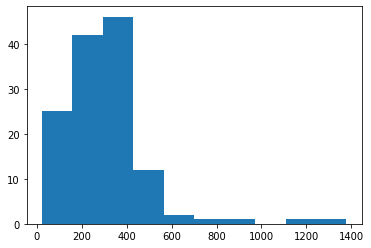

Average Levenshtein distance for 'Fight' Q-A pairs:  349.10526315789474


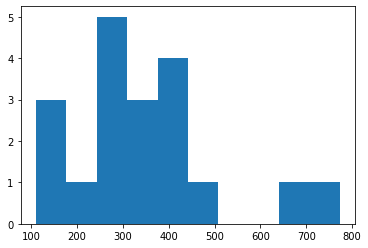

In [66]:
# Average Levenshtein distance for 'Flight' avoidance
print('Average Levenshtein distance for \'Flight\' Q-A pairs: ', sum(flight_distances)/j)
fig = plt.hist(flight_distances)
plt.show()

# Average Levenshtein distance for 'Fight' avoidance
print('Average Levenshtein distance for \'Fight\' Q-A pairs: ', sum(fight_distances)/k)
fig = plt.hist(fight_distances)
plt.show()

In [67]:
# Percentiles for non-avoidance
print('10% percentile for non-avoidance Q-A pairs: ', np.percentile(non_av_distances, 10))
print('90% percentile for non-avoidance Q-A pairs: ', np.percentile(non_av_distances, 90))

10% percentile for non-avoidance Q-A pairs:  138.39999999999998
90% percentile for non-avoidance Q-A pairs:  491.80000000000007


In [68]:
# Average Levenshtein distance for avoidance Q-A pairs
av_distances = flight_distances
for d in fight_distances:
    av_distances.append(d)
    
print('10% percentile for avoidance Q-A pairs: ', np.percentile(av_distances, 10))
print('90% percentile for avoidance Q-A pairs: ', np.percentile(av_distances, 90))

# Flight
print('10% percentile for flight avoidance Q-A pairs: ', np.percentile(flight_distances, 10))
print('90% percentile for flight avoidance Q-A pairs: ', np.percentile(flight_distances, 90))

# Fight
print('10% percentile for fight avoidance Q-A pairs: ', np.percentile(fight_distances, 10))
print('90% percentile for fight avoidance Q-A pairs: ', np.percentile(fight_distances, 90))

10% percentile for avoidance Q-A pairs:  127.7
90% percentile for avoidance Q-A pairs:  466.79999999999995
10% percentile for flight avoidance Q-A pairs:  127.7
90% percentile for flight avoidance Q-A pairs:  466.79999999999995
10% percentile for fight avoidance Q-A pairs:  152.4
90% percentile for fight avoidance Q-A pairs:  502.39999999999986
